## SARIMA Model Development

#### Introduction to SARIMA
The SARIMA (Seasonal Autoregressive Integrated Moving Average) model is an extension of the ARIMA model that explicitly supports univariate time series data with a seasonal component. The model is well-suited for data with strong seasonal patterns. SARIMA incorporates both non-seasonal and seasonal parts in the modeling process.


In [17]:
import pandas as pd
import numpy as np
import itertools
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


#### Data Splitting
The dataset is first split into training and testing sets. This involves separating the features from the target variable and ensuring the data has a continuous date range without duplicates. The data is then split into training and testing sets using an 80-20 split.


In [18]:
def split_data(data):
    # Define your features and target variable
    X = data.drop(['TotalPrice', 'InvoiceDate'], axis=1)
    y = data['TotalPrice']

    # Ensure that y has a DatetimeIndex and remove duplicates
    y.index = pd.to_datetime(data['InvoiceDate'])
    y = y[~y.index.duplicated(keep='first')]
    y = y.sort_index()  # Ensure the index is monotonic

    # Create a date range covering the entire period
    date_range = pd.date_range(start=y.index.min(), end=y.index.max(), freq='D')

    # Reindex y to daily frequency and align X accordingly
    y = y.reindex(date_range).fillna(0)
    X = X.reindex(date_range).fillna(0)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


#### Hyperparameter Tuning
The `tune_sarima` function explores various combinations of non-seasonal and seasonal parameters to find the best SARIMA model based on the Akaike Information Criterion (AIC). The model with the lowest AIC is selected. Additionally, the function calculates RMSE for training and testing sets to plot the learning curve.


In [19]:
def tune_sarima(y_train, y_test):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None
    best_model = None
    rmse_train = []
    rmse_test = []

    warnings.filterwarnings("ignore")

    def evaluate_sarima(param, param_seasonal):
        try:
            model = SARIMAX(y_train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)
            train_rmse = np.sqrt(mean_squared_error(y_train, results.fittedvalues))
            pred = results.forecast(steps=len(y_test))
            test_rmse = np.sqrt(mean_squared_error(y_test, pred))
            return results.aic, param, param_seasonal, results, train_rmse, test_rmse
        except Exception as e:
            return float("inf"), None, None, None, None, None

    results = Parallel(n_jobs=-1)(delayed(evaluate_sarima)(param, param_seasonal) for param in pdq for param_seasonal in seasonal_pdq)

    for aic, param, param_seasonal, model, train_rmse, test_rmse in results:
        if aic < best_aic:
            best_aic = aic
            best_order = param
            best_seasonal_order = param_seasonal
            best_model = model
        if train_rmse is not None and test_rmse is not None:
            rmse_train.append(train_rmse)
            rmse_test.append(test_rmse)

    print(f'Best SARIMA order: {best_order}')
    print(f'Best seasonal order: {best_seasonal_order}')
    print(f'Best SARIMA model AIC: {best_aic}')
    return best_model, best_order, best_seasonal_order, rmse_train, rmse_test


#### Plotting the Learning Curve
The learning curve, representing the RMSE over iterations for both training and testing sets, is plotted to visualize the model's performance and convergence over time.


In [20]:
def plot_learning_curve(rmse_train, rmse_test):
    plt.figure(figsize=(10, 6))
    plt.plot(rmse_train, label='Train')
    plt.plot(rmse_test, label='Test')
    plt.title('SARIMA RMSE')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()


#### Model Validation
The `validate_model` function generates predictions using the trained SARIMA model and calculates various performance metrics, including MAE, RMSE, MASE, and WMAPE.


In [21]:
def validate_model(model, y_test):
    predictions = model.forecast(steps=len(y_test))

    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    if np.mean(np.abs(np.diff(y_test))) != 0:
        mase = mae / np.mean(np.abs(np.diff(y_test)))
    else:
        mase = float('inf')
    wmape = np.sum(np.abs(predictions - y_test)) / np.sum(y_test) if np.sum(y_test) != 0 else float('inf')

    metrics = {
        'MAE (Total)': mae,
        'RMSE (Total)': rmse,
        'MASE (Total)': mase,
        'WMAPE (Total)': wmape
    }
    return metrics, predictions


#### Diagnostic Check
The `diagnostic_check` function plots the true values against the predictions to visually inspect the model's performance.


In [22]:
def diagnostic_check(y_test, predictions):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='True Values')
    plt.plot(predictions, label='Predictions')
    plt.title('SARIMA Model - True vs Predictions')
    plt.xlabel('Time')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.grid(True)
    plt.show()


#### Decompose Seasonal Component
The `decompose_seasonal_component` function decomposes the seasonal component of the data using the STL (Seasonal and Trend decomposition using Loess) method.


In [23]:
def decompose_seasonal_component(data):
    daily_sales = data['TotalPrice'].resample('D').sum().fillna(0)
    stl = STL(daily_sales, seasonal=7)
    result = stl.fit()
    return result


#### Calculate Seasonal Metrics
The `calculate_seasonal_metrics` function calculates seasonal performance metrics using the seasonal component of the data.


In [24]:
def calculate_seasonal_metrics(model, y_test, seasonal_component):
    predictions = model.forecast(steps=len(y_test))

    smae = mean_absolute_error(seasonal_component[-len(predictions):], predictions)
    srmse = np.sqrt(mean_squared_error(seasonal_component[-len(predictions):], predictions))

    seasonal_metrics = {
        'MAE (Seasonal)': smae,
        'RMSE (Seasonal)': srmse
    }

    return seasonal_metrics


#### Plot Seasonal Comparisons
The `plot_seasonal_comparisons` function plots the true seasonal component against the predicted seasonal component.


In [25]:
def plot_seasonal_comparisons(y_test, predictions, seasonal_component):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, seasonal_component[-len(y_test):], label='True Seasonal')
    plt.plot(y_test.index, predictions, label='Predicted Seasonal')
    plt.title('True vs Predicted Seasonal Components')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()


#### Plot Seasonal Decomposition
The `plot_seasonal_decomposition` function plots the components of the seasonal decomposition.


In [26]:
def plot_seasonal_decomposition(stl_result):
    stl_result.plot()
    plt.show()


#### Main Function
The `main_sarima` function orchestrates the data processing, model training, hyperparameter tuning, validation, and diagnostics. It also logs the chosen hyperparameters and the calculated performance metrics.


/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates

/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates

/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._ini

/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._ini

/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, f

/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates

/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dacawave/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates

Best SARIMA order: (0, 0, 1)
Best seasonal order: (0, 1, 1, 12)
Best SARIMA model AIC: 3054.5709378848455
Chosen hyperparameters: (0, 0, 1), seasonal: (0, 1, 1, 12)


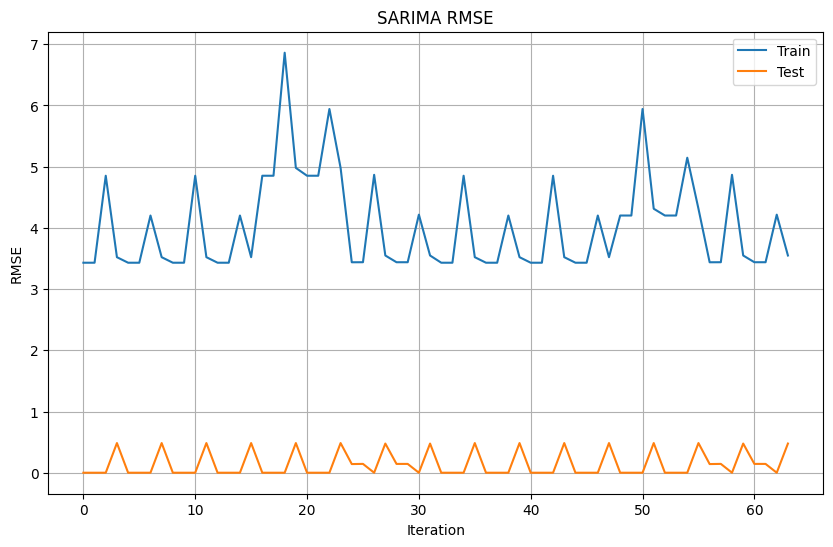

SARIMA Model Performance:
MAE (Total): 0.13800329025576205
RMSE (Total): 0.4846516276291117
MASE (Total): inf
WMAPE (Total): inf


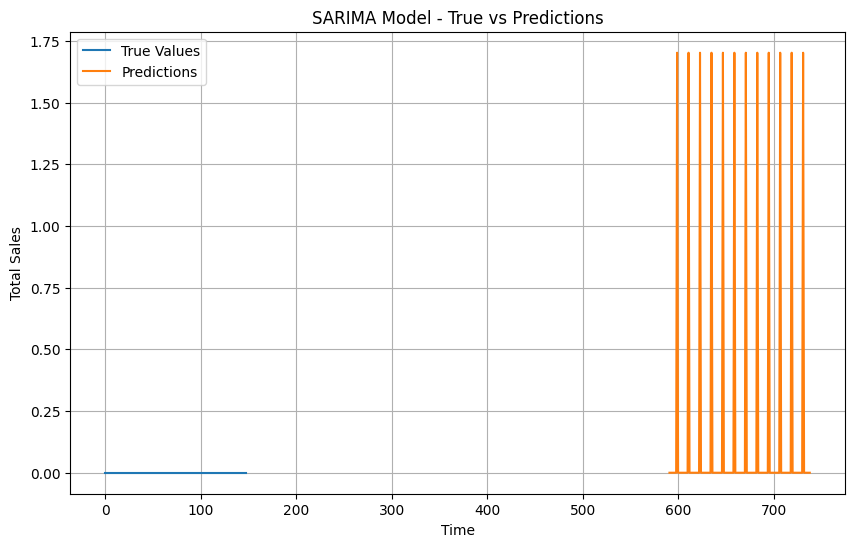

Seasonal Metrics: {'MAE (Seasonal)': 12512.470293553308, 'RMSE (Seasonal)': 16996.223203608075}


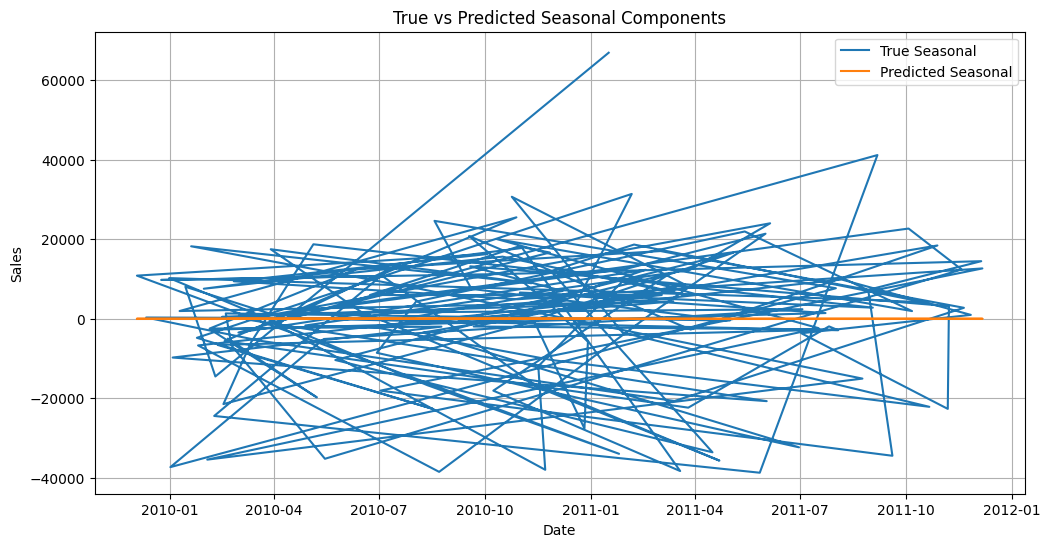

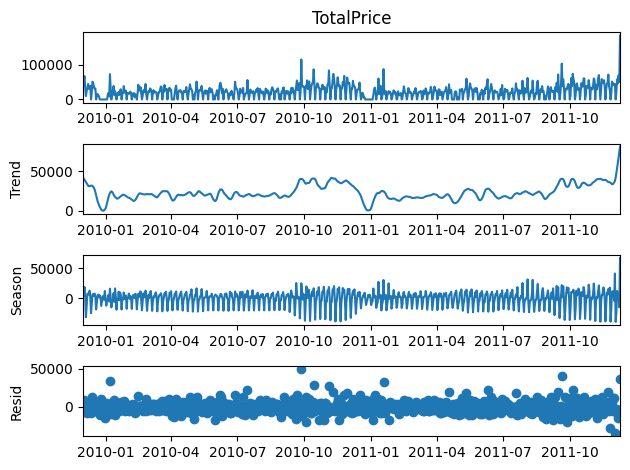

Model performance metrics updated and saved to model_performance_metrics.csv


In [27]:
def main_sarima(file_path, metrics_df_path):
    data = pd.read_csv(file_path)
    X_train, X_test, y_train, y_test = split_data(data)

    stl_result = decompose_seasonal_component(data)
    seasonal_component = stl_result.seasonal

    best_sarima_model, best_order, best_seasonal_order, rmse_train, rmse_test = tune_sarima(y_train, y_test)
    print(f'Chosen hyperparameters: {best_order}, seasonal: {best_seasonal_order}')
    plot_learning_curve(rmse_train, rmse_test)
    metrics, predictions = validate_model(best_sarima_model, y_test)

    print(f'SARIMA Model Performance:')
    for metric, value in metrics.items():
        print(f'{metric}: {value}')
        
    diagnostic_check(y_test, predictions)
    
    seasonal_metrics = calculate_seasonal_metrics(best_sarima_model, y_test, seasonal_component)
    print(f'Seasonal Metrics: {seasonal_metrics}')

    plot_seasonal_comparisons(y_test, predictions, seasonal_component)
    plot_seasonal_decomposition(stl_result)

    # Load or create a metrics DataFrame
    try:
        metrics_df = pd.read_csv(metrics_df_path)
    except FileNotFoundError:
        metrics_df = pd.DataFrame(columns=['Model', 'MAE (Total)', 'RMSE (Total)', 'MASE (Total)', 'WMAPE (Total)', 'MAE (Seasonal)', 'RMSE (Seasonal)'])

    metrics['Model'] = 'SARIMA'
    metrics.update(seasonal_metrics)
    metrics_df = metrics_df.append(metrics, ignore_index=True)

    # Save the updated metrics DataFrame
    metrics_df.to_csv(metrics_df_path, index=False)
    print('Model performance metrics updated and saved to', metrics_df_path)

# File paths
file_path = 'preprocessed_data.csv'
metrics_df_path = 'model_performance_metrics.csv'
main_sarima(file_path, metrics_df_path)
